In [2]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.SpaceMMiCRM, MLSolver

In [3]:
using CairoMakie, ProgressLogging
using Base.Threads
using BenchmarkTools

# ODE/PDE Solving

## Basic no space solve

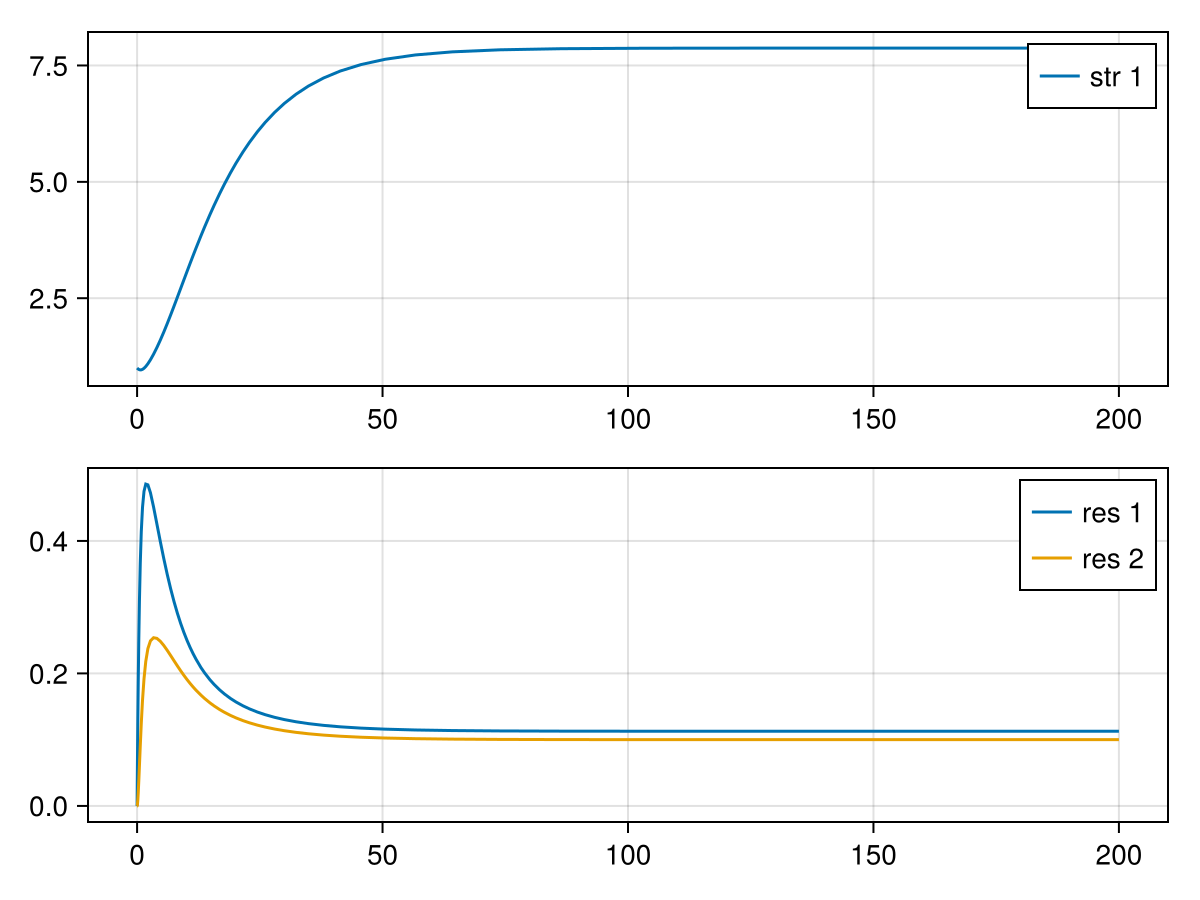

3-element Vector{Float64}:
 7.8729848580251485
 0.11270164600437772
 0.09999998483864031

In [54]:
D = fill(0., 1, 2, 2)
D[1, 2, 1] = 1.
c = [1. 1.]
l = [1. 0.]

p = make_mmicrm_smart(1, 2, 200;
    D, c, l,
    K=[1., 0.],
    r=[1., 1.],
    m=[0.1],
    u0=:onlyN,
    u0rand=0.
)
s = solve(p)
display(plot_mmicrm_sol(s))
s[end]
#param_summary(p.p)

#### Steady state solving

In [55]:
symsol = symbolic_solve_ode_ml(p)

┌ Warning: Solve::ratnz: Solve was unable to solve the system with inexact coefficients.
│     The answer was obtained by solving a corresponding exact system and
│     numericizing the result.
└ @ MathLink ~/.julia/packages/MathLink/S39uA/src/eval.jl:16


3-element Vector{Vector{Pair{Symbolics.Num, Symbolics.Num}}}:
 [u1 => 0.0, u2 => 1.0, u3 => 0.0]
 [u1 => 0.12701665379258312, u2 => 0.8872983346207417, u3 => 0.1]
 [u1 => 7.872983346207417, u2 => 0.11270166537925831, u3 => 0.1]

In [56]:
sssol = solve(SteadyStateProblem(p), DynamicSS())
show(sssol)

[7.872887397594479, 0.1127028950432394, 0.1000009622883371]

## Linear stability analysis

In [69]:
usol = s.u[end]
show(uninplace(mmicrmfunc!)(usol, p.p, 0))

[-1.1936515530959768e-7, 1.5286459875696323e-9, 1.1909763175665944e-9]

maximum(real(lambdas)) = 0.005716023980582239


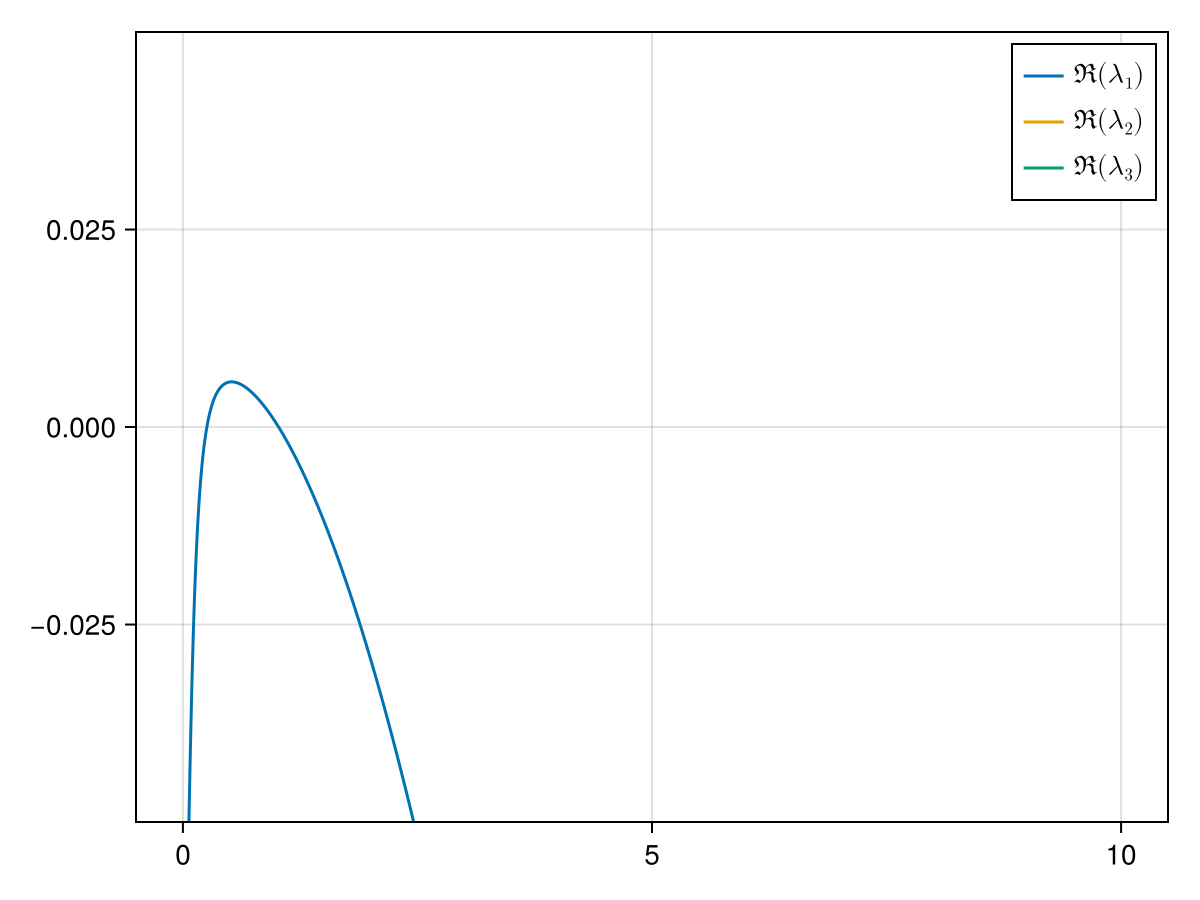

In [297]:
ks = LinRange(0., 10., 10000)
Ds = [0.01, 1000, 0.1]

lambdas = do_linstab_for_ks(ks, p, Ds, usol);
@show maximum(real(lambdas))
faa = plot_linstab_lambdas(ks, lambdas[:,:])
ylims!(faa.axis, (-0.05, 0.05))
# xlims!(faa.axis, (0., 2.))
faa

In [298]:
 Finds the k with the biggest maximum eigenvalue
kmax_i = argmax(maximum.(eachrow(real(lambdas))))
kmax = ks[kmax_i]
kmax_i, kmax

LoadError: UndefVarError: `Finds` not defined

In [299]:
ff = linstab_make_full_func(p.p, usol, Ds)
kmax_es = ff(kmax)
kmax_es.vectors[:,1] # the eigensystem is sorted by evalue so this is the one

3-element Vector{Float64}:
 -0.9999991506978682
  1.2908577034749705e-5
 -0.0013032409259218977

## Spatial stuff - 1D!

In [300]:
ssize = (1000,)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.1, 0.1)
space = make_cartesianspace_smart(length(ssize); dx=0.05, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 10000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((3, 1000), 18, CartesianSpace{1, Tuple{Periodic}, Float64}([0.05]))

#### Direct solver

In [301]:
@time sps = solve(sp, QNDF(); maxiters=1000)
display(sps.retcode)
display(sps.destats.nf)
@show length(sps.u)

  0.197466 seconds (187.04 k allocations: 209.088 MiB)


ReturnCode.Success = 1

753

length(sps.u) = 172


172

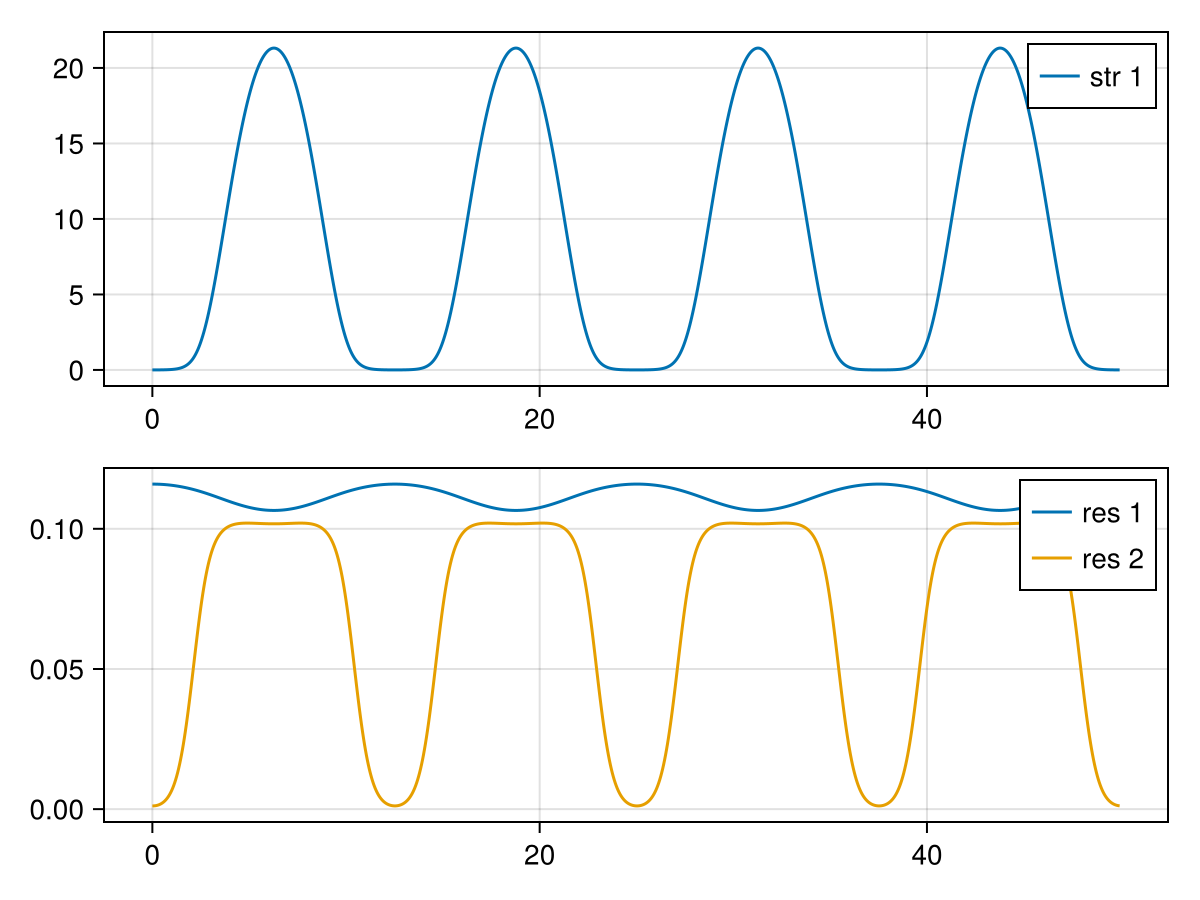

In [302]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps(10000))

In [161]:
sps.stats

SciMLBase.DEStats
Number of function 1 evaluations:                  3251
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    182
Number of linear solves:                           2452
Number of Jacobians created:                       40
Number of nonlinear solver iterations:             2193
Number of nonlinear solver convergence failures:   13
Number of fixed-point solver iterations:                     0
Number of fixed-point solver convergence failures:           0
Number of rootfind condition calls:                0
Number of accepted steps:                          476
Number of rejected steps:                          49

#### Steady state solver

 12.204321 seconds (836.84 k allocations: 2.199 GiB, 1.90% gc time)


ReturnCode.Success = 1

2803

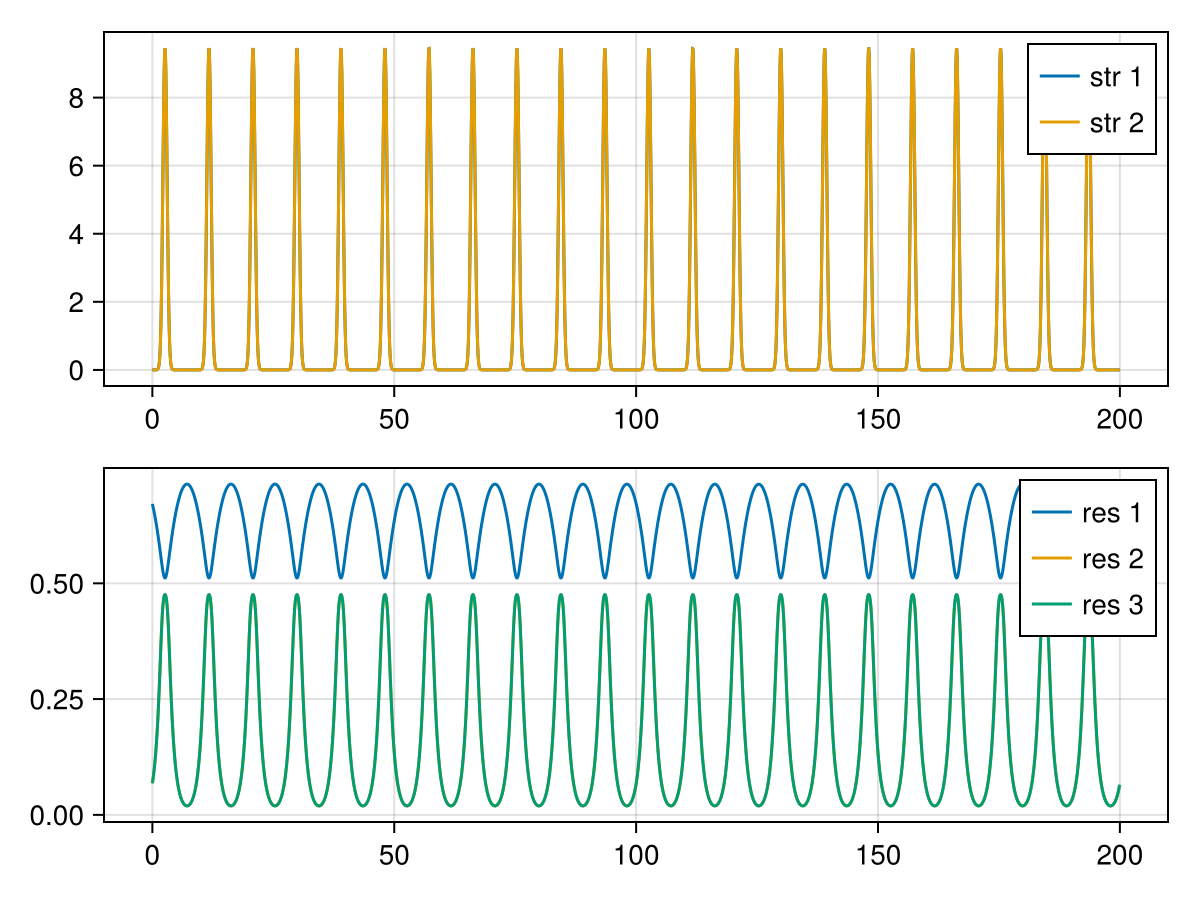

In [87]:
sssp = SteadyStateProblem(sp)
@time sssps = solve(sssp, DynamicSS(QNDF()); maxiters=1000)
display(sssps.retcode)
display(sssps.original.destats.nf)
plot_1dsmmicrm_sol_snap(sssps.prob.p, sssps.u)

## Spatial stuff - 2D!

In [343]:
ssize = (60,60)
su0 = expand_u0_to_size(ssize, usol)
psu0 = perturb_u0_uniform(get_Ns(p.p)..., su0, 0.01, 0.01)
space = make_cartesianspace_smart(length(ssize); dx=0.5, bcs=Periodic())
usenthreads = prod(ssize) >= 100 ? nthreads() : nothing
sp = make_smmicrm_problem_safe(
    psu0, 1000000, p.p, SA[Ds...], space, usenthreads;
)
size(sp.u0), sp.p.usenthreads, sp.p.space

((3, 60, 60), 18, CartesianSpace{2, Tuple{Periodic, Periodic}, Float64}([0.5, 0.5]))

#### Direct solver

In [344]:
@time sps = solve(sp, QNDF(); maxiters=1000)
display(sps.retcode)
display(sps.destats.nf)
#display(plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end-1]))
#plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])

 11.810692 seconds (460.56 k allocations: 3.505 GiB, 2.11% gc time)


ReturnCode.Success = 1

1672

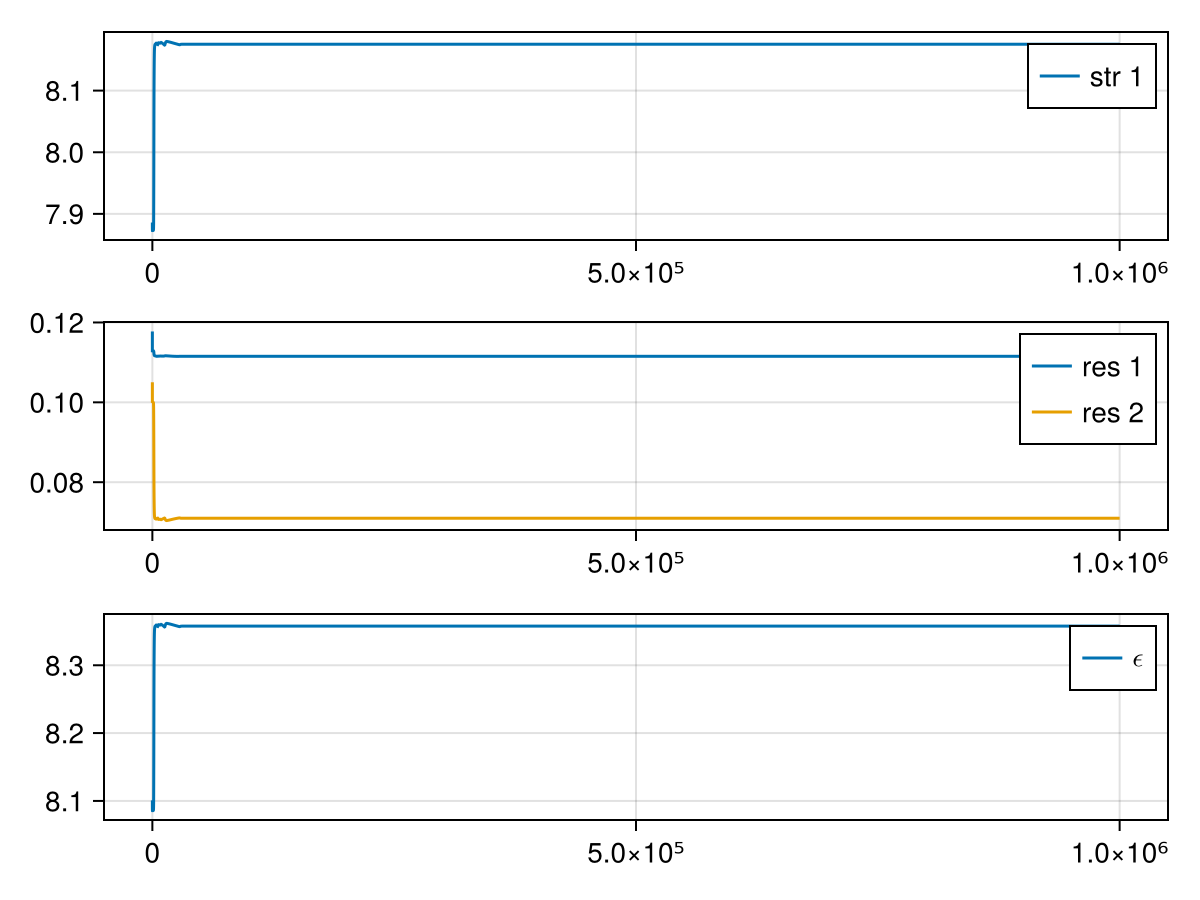

In [345]:
plot_smmicrm_sol_avgs(sps; plote=true)

In [ ]:
heatmap(sps(sps.t[end])[1,:,:])

# Symbolics

# Extras

In [263]:
GC.gc()
empty!(Out)

Dict{Int64, Any}()